In [1]:
from __future__ import division, print_function

import os
import argparse
import cv2
import numpy as np
import tensorflow as tf
from utils import preserve_colors_np
from utils import get_files, get_img, get_img_crop, save_img, resize_to
import scipy
from scipy.ndimage.filters import gaussian_filter
import time
from inference import AdaINference
from IPython.display import Image

Using TensorFlow backend.


In [2]:
checkpoint= "checkpoints/checkpoints2/parameters2_4"
vgg_path = "models/vgg_normalised.t7"
device = '/gpu:0'
content_path = 'images/inputs/'
style_path = 'images/styles/style2'
out_path = 'images/outputs_jupyter/'
content_size = int(0)
alpha = int(1)
passes = int(1)
concat = False
style_size = int(512)
crop_size = int(256)
keep_colors = False

In [3]:

start = time.time()

# Load the AdaIN model
ada_in = AdaINference(checkpoint, vgg_path, device)

# Get content & style full paths
if os.path.isdir(content_path):
    content_files = get_files(content_path)
else: # Single image file
    content_files = [content_path]
if os.path.isdir(style_path):
    style_files = get_files(style_path)
else: # Single image file
    style_files = [style_path]


count = 0


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg_input (InputLayer)       (None, None, None, 3)     0         
_________________________________________________________________
preprocess (Conv2D)          (None, None, None, 3)     12        
_________________________________________________________________
lambda_1 (Lambda)            (None, None, None, 3)     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, None, None, 64)    1792      
_________________________________________________________________
relu1_1 (Activation)         (None, None, None, 64)    0         
_________________________________________________________________
lambda_2 (Lambda)            (None, None, None, 64)    0         
_________________________________________________________________
conv1_2 (Conv2D)             (None, None, None, 64)    36928     
__________

In [4]:
for content_fullpath in content_files:
        content_prefix, content_ext = os.path.splitext(content_fullpath)
        content_prefix = os.path.basename(content_prefix)  # Extract filename prefix without ext

        content_img = get_img(content_fullpath)
        if content_size > 0:
            content_img = int(resize_to(content_img, content_size))

        for style_fullpath in style_files: 
            style_prefix, _ = os.path.splitext(style_fullpath)
            style_prefix = os.path.basename(style_prefix)  # Extract filename prefix without ext

            style_img = get_img_crop(style_fullpath, resize=style_size, crop=crop_size)
            # style_img = get_img(style_fullpath)

            if keep_colors:
                style_img = preserve_colors_np(style_img, content_img)

            # if args.noise:  # Generate textures from noise instead of images
            #     frame_resize = np.random.randint(0, 256, frame_resize.shape, np.uint8)
            #     frame_resize = gaussian_filter(frame_resize, sigma=0.5)

            # Run the frame through the style network
            stylized_rgb = ada_in.predict(content_img, style_img, alpha)

            if passes > 1:
                for _ in range(passes-1):
                    stylized_rgb = ada_in.predict(stylized_rgb, style_img, alpha)

            # Stitch the style + stylized output together, but only if there's one style image
            if concat:
                # Resize style img to same height as frame
                style_img_resized = int(scipy.misc.imresize(style_img, (stylized_rgb.shape[0], stylized_rgb.shape[0])))
                stylized_rgb = np.hstack([style_img_resized, stylized_rgb])

            # Format for out filename: {out_path}/{content_prefix}_{style_prefix}.{content_ext}
            out_f = os.path.join(out_path, '{}_{}{}'.format(content_prefix, style_prefix, content_ext))
            # out_f = f'{content_prefix}_{style_prefix}.{content_ext}'
            
            save_img(out_f, stylized_rgb)

            count += 1
            print("{}: Wrote stylized output image to {}".format(count, out_f))

print("Finished stylizing {} outputs in {}s".format(count, time.time() - start))

1: Wrote stylized output image to images/outputs_jupyter/harry_potter_leonid_afremov.jpg
2: Wrote stylized output image to images/outputs_jupyter/campus_nord_leonid_afremov.jpg
3: Wrote stylized output image to images/outputs_jupyter/livingroom_leonid_afremov.png
Finished stylizing 3 outputs in 12.714599132537842s


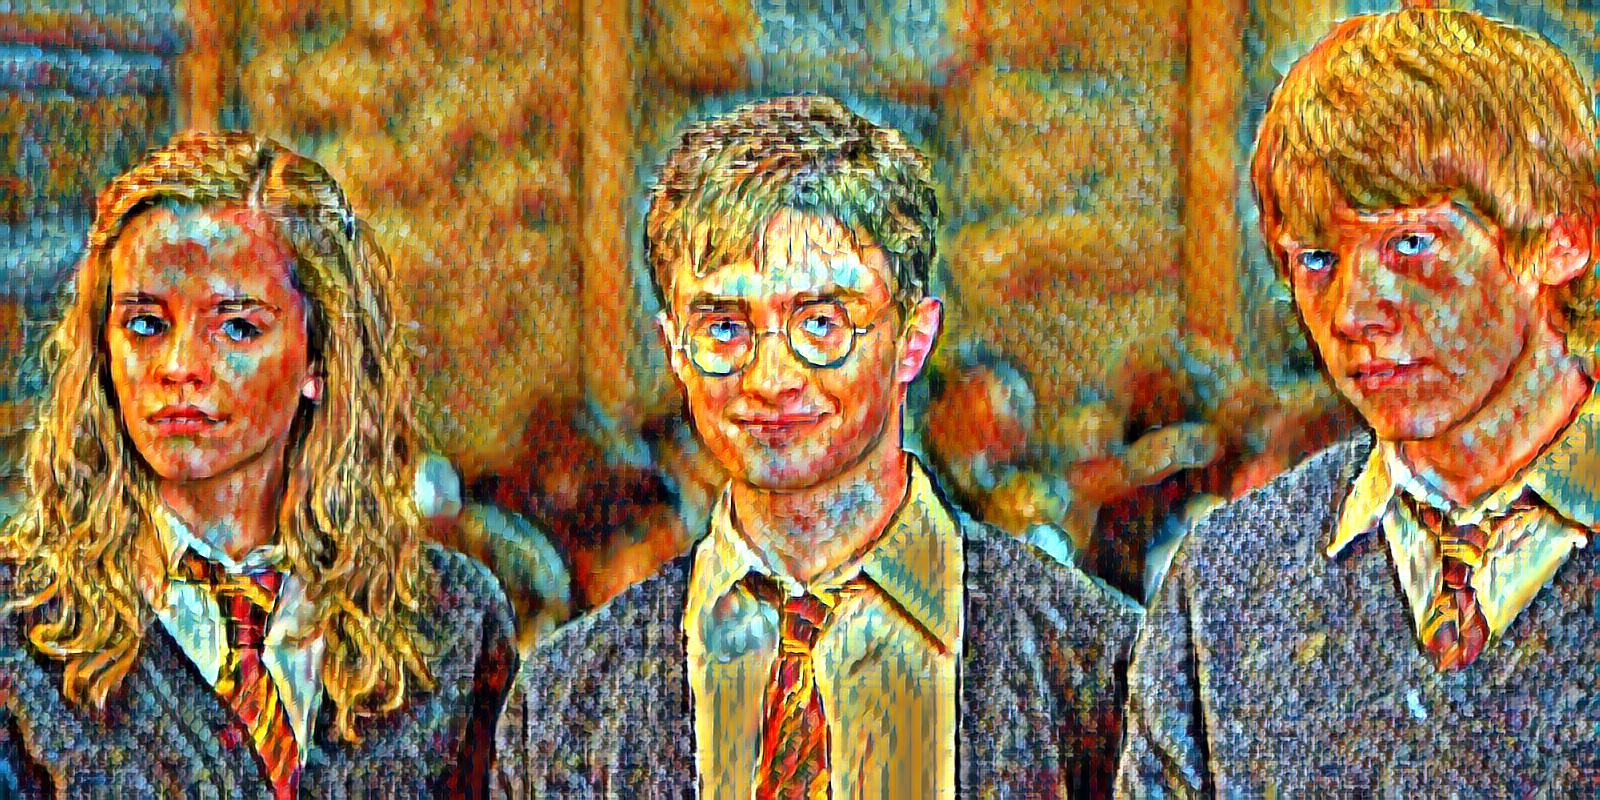

In [10]:
Image(filename='images/outputs_jupyter/harry_potter_leonid_afremov.jpg')


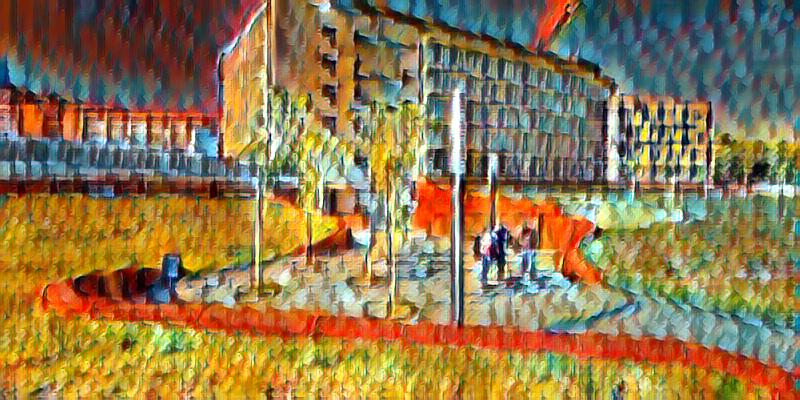

In [13]:

Image('images/outputs_jupyter/campus_nord_leonid_afremov.jpg')



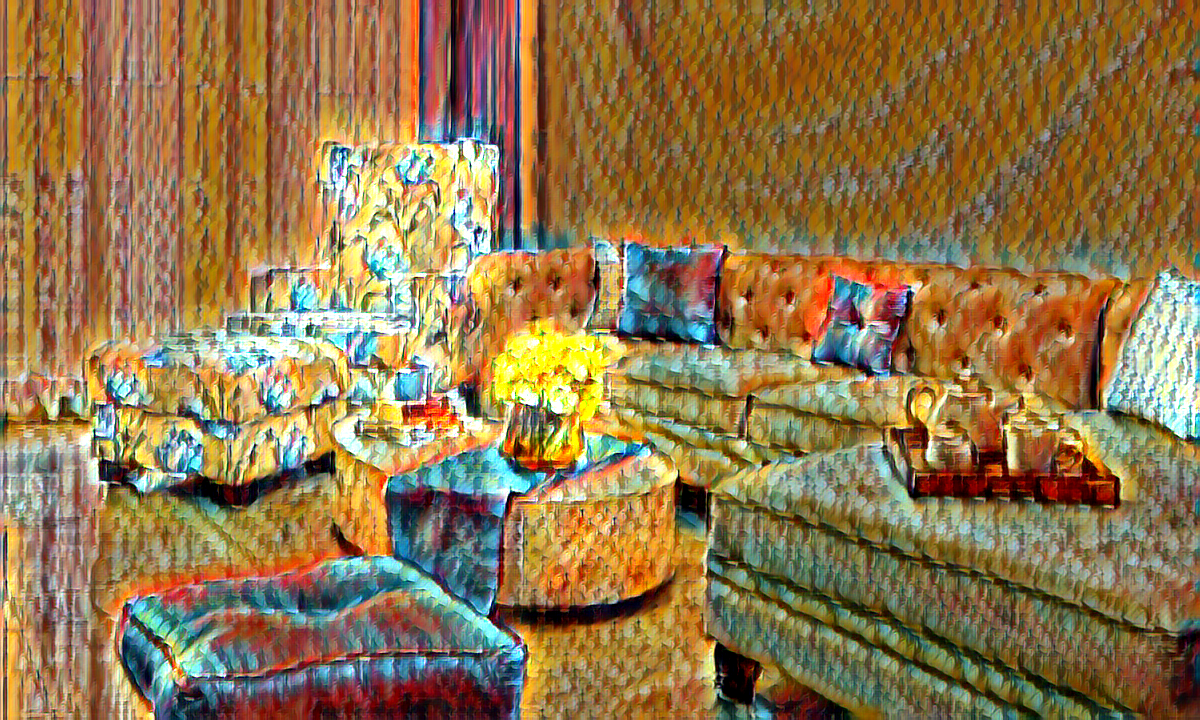

In [12]:

Image('images/outputs_jupyter/livingroom_leonid_afremov.png')